In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
# import pickle

import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

In [3]:
def entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log(Pdf_safe))

def information(Pdf):
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return - Pdf_safe * np.log2(Pdf_safe)

def Shannon_entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log2(Pdf_safe))

In [4]:
location = 'Cape_Hatteras'
member = 49
delta_r = 0.1

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/spatial/dr_{delta_r*100:03.0f}/{location}_dr{delta_r*100:03.0f}_m{member:03d}.zarr"

P_m = xr.open_zarr(file_path)

# file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_all.zarr"
# P_AX = xr.open_zarr(file_path_AX)

In [6]:
P_m.trajectory

<xarray.DataArray 'trajectory' (trajectory: 1001)> Size: 8kB
array([   0,    1,    2, ...,  998,  999, 1000])
Coordinates:
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999 1000

In [7]:
# randomly sample 20 trajectories out of the 1000
P_m = P_m.isel(trajectory=np.random.choice(P_m.trajectory, 20, replace=False))

In [10]:
len(P_m.trajectory)

20

In [42]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

In [44]:
# get dimensions
Members = [1, 2, 44, 46, 47, 48, 49, 50]
std_ranges = np.linspace(1, 20, 20)/100
delta_t_array = P_m.delta_t.values
time_array = P_m.time.values
bin_length = P_m.hexint.shape[0]

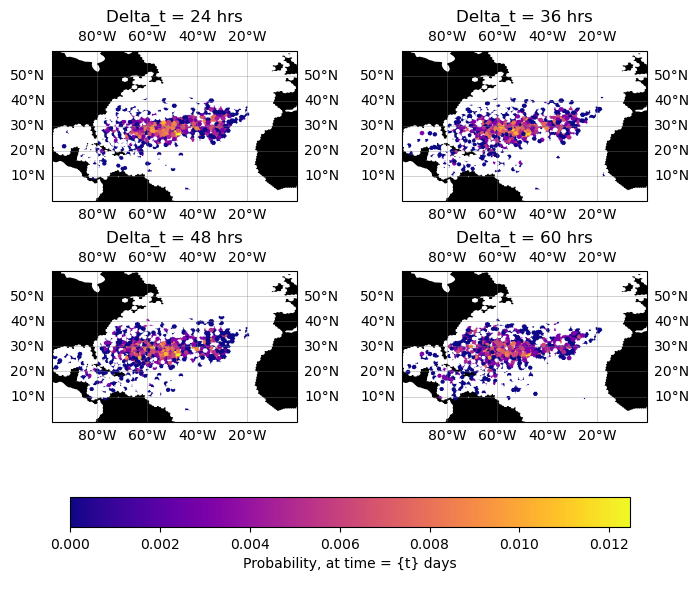

In [128]:
ncol = 2
nrow = 3
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(7, 6),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)
t = 1200

for i, dt in enumerate(delta_t_array):
    
    axs[i].set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'Delta_t = {dt} hrs')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5)

    im = hexbin_grid.pcolorhex(P_m['probability'][i, :, t].values, ax=axs[i], cmap='plasma', draw_edges=False)



for i in range(ncol*nrow - nrow +1, ncol*nrow):
    axs[i].axis('off')
    
bar_ax = fig.add_axes([0.1, 0.13, 0.8, 0.05])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Probability, at time = {t} days')

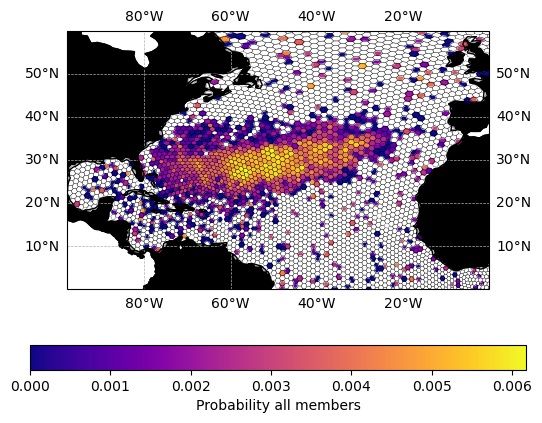

In [108]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

t = 1000
t_gap = 0

im = hexbin_grid.pcolorhex(P_AX['probability'][t_gap, :, t].values, ax=ax, cmap='plasma', draw_edges=True)
# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label='Probability all members')

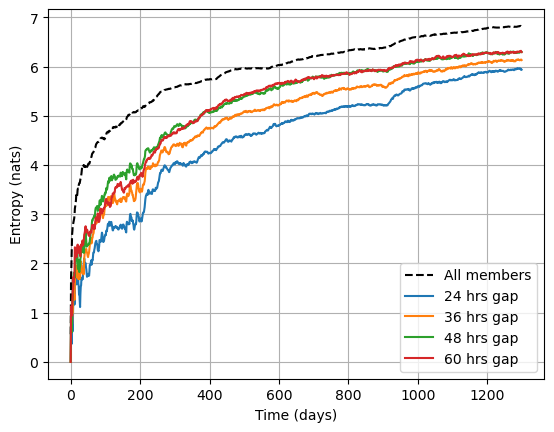

In [52]:
plt.plot(P_AX['entropy'][0, :1300], ls='--', color='black', label='All members')

for i, dt in enumerate(delta_t_array):
    plt.plot(P_m['entropy'][i, :1300], label=f'{dt} hrs gap')

plt.legend()
plt.ylabel('Entropy (nats)')
plt.xlabel('Time (days)')
plt.grid()

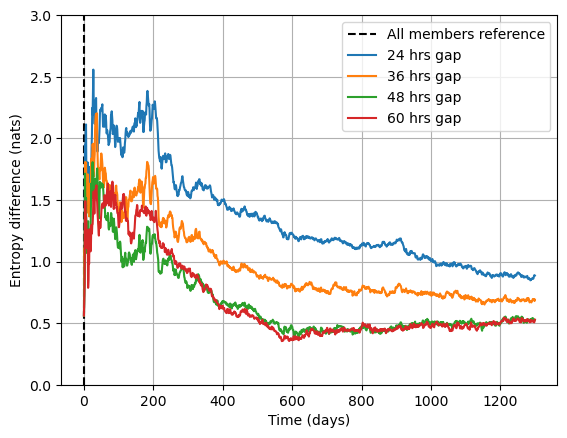

In [54]:
# plt.plot(P_AX['entropy'][0, :1300], ls='--', color='black', label='All members')

plt.axvline(0, color='black', ls='--', label="All members reference")
for i, dt in enumerate(delta_t_array):
    plt.plot(P_AX['entropy'][0, :1300] - P_m['entropy'][i, :1300], label=f'{dt} hrs gap')
    
plt.legend()
plt.ylabel('Entropy difference (nats)')
plt.xlabel('Time (days)')
plt.ylim(0, 3)
plt.grid()

In [122]:
def compute_h_timescales(P_AX, P_m, i):
    """
    Computes the timescales at which the entropy values in P_m reach the same or higher values as in P_AX.

    Parameters:
    - P_AX: DataFrame or similar structure with 'entropy' values for reference.
    - P_m: DataFrame or similar structure with 'entropy' values to compare.
    - i: Index to select the specific member in P_m for comparison.

    Returns:
    - h_timescales: A numpy array containing the computed timescales.
    """
    h_ref, h_m = P_AX['entropy'][i, :1300].values, P_m['entropy'][i, :1300].values

    max_h = np.nanmax(h_m)
    h_range = np.linspace(0.1, max_h, 10)

    h_timescales = np.zeros_like(h_range)

    for j, h_i in enumerate(h_range):
        idx_ref = np.where(h_ref >= h_i)[0]
        idx_m = np.where(h_m >= h_i)[0]
        if len(idx_ref) > 0 and len(idx_m) > 0:
            h_timescales[j] = idx_m[0] - idx_ref[0]
        else:
            h_timescales[j] = np.nan  # Assign NaN if no matching index is found

    return h_timescales, h_range

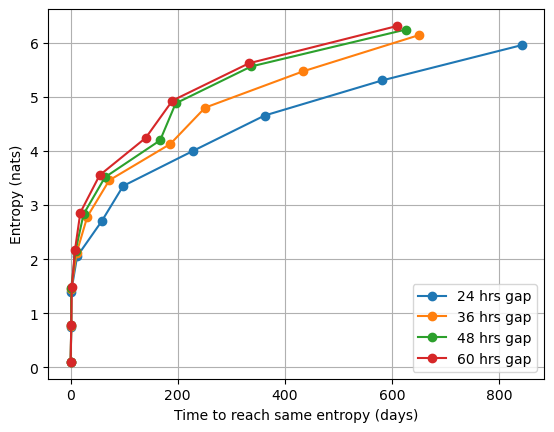

In [123]:
for i, dt in enumerate(delta_t_array):
    
    x, y =  compute_h_timescales(P_AX, P_m, i)
    plt.plot(x,y, marker='o', label=f'{dt} hrs gap')

plt.grid()
plt.xlabel('Time to reach same entropy (days)')
plt.ylabel('Entropy (nats)')
plt.legend()

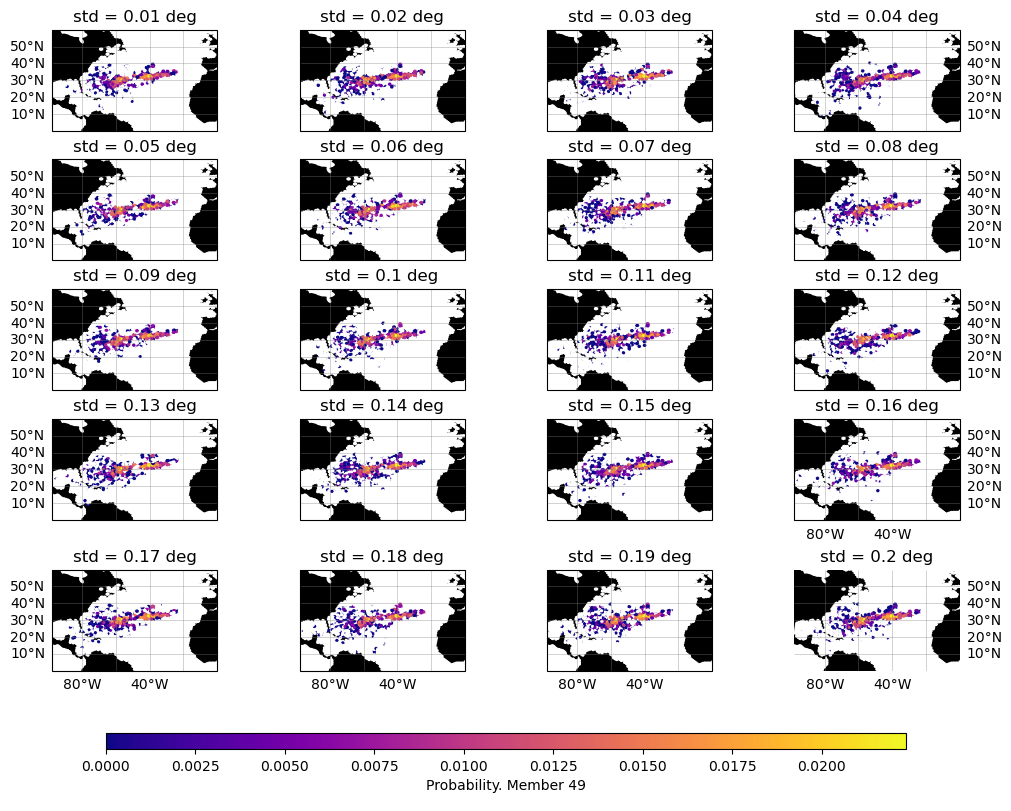

In [129]:
ncol = 4
nrow = 6
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(10, 8),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)
t = 800

for i, std in enumerate(std_ranges):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    axs[i].set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'std = {std} deg')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5)

    im = hexbin_grid.pcolorhex(P_m['probability'][0, :, t].values, ax=axs[i], cmap='plasma', draw_edges=False)
    
    
    if i in [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19]:
        gl.left_labels = False

    if i < 15:
        gl.bottom_labels = False

    gl.top_labels = False
    gl.right_labels = False

    if i in [3, 7, 11, 15, 19]:
        gl.right_labels = True

for i in range(ncol*nrow - nrow +1, ncol*nrow):
    axs[i].axis('off')

# ax[12].legend(handles=[h], loc='upper center', shadow=True)
bar_ax = fig.add_axes([0.1, 0.07, 0.8, 0.02])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal', label=f'Probability. Member {member}')

plt.savefig(f'../stds_maps{std*100:03.0f}_m{member:03d}.zarr.jpg')

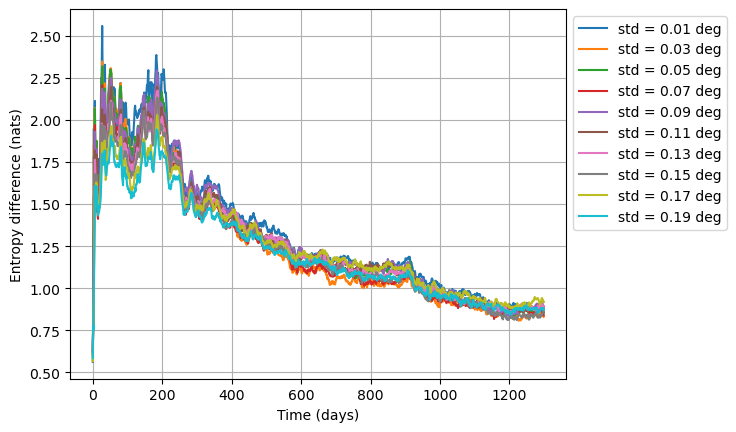

In [125]:
for i, std in enumerate(std_ranges[::2]):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_all.zarr"
    P_AX = xr.open_zarr(file_path_AX)
    
    plt.plot(P_AX['entropy'][0, :1300] - P_m['entropy'][0, :1300], label=f'std = {std} deg')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('Entropy difference (nats)')
plt.xlabel('Time (days)')
plt.grid()

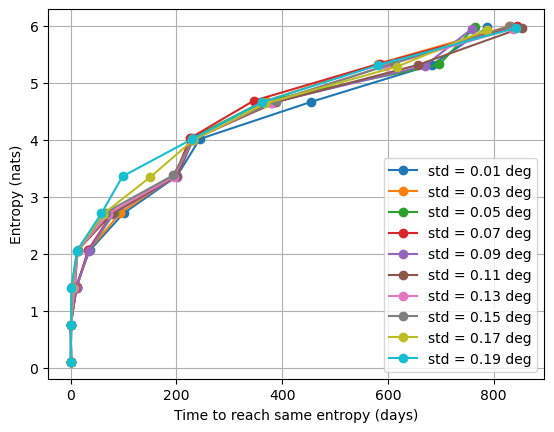

In [127]:
for i, std in enumerate(std_ranges[::2]):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_all.zarr"
    P_AX = xr.open_zarr(file_path_AX)
    
    x, y =  compute_h_timescales(P_AX, P_m, 0)
    plt.plot(x,y, marker='o', label=f'std = {std} deg')

plt.grid()
plt.xlabel('Time to reach same entropy (days)')
plt.ylabel('Entropy (nats)')
plt.legend()

# New set of simulations SPATIAL

In [3]:
location = 'Cape_Hatteras'
member = 1
delta_r = 0.1

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
P_m = xr.open_zarr(file_path)

hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)


In [5]:
P_m['entropy']

<xarray.DataArray 'entropy' (time: 730)> Size: 6kB
dask.array<open_dataset-entropy, shape=(730,), dtype=float64, chunksize=(730,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int32 3kB 0 1 2 3 4 5 6 7 ... 723 724 725 726 727 728 729
Attributes:
    description:  Entropy values for each time step and observation time
    units:        bits

In [6]:
location = 'Cape_Hatteras'
N_members = 7
N_obs = len(P_m.time)
H = np.zeros((N_members, N_obs))
delta_r = 1.

for member in range(1,N_members+1):
    print(f"Member {member}")
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    H[member-1, :] = P_m['entropy'].values

Member 1
Member 2
Member 3
Member 4
Member 5
Member 6
Member 7


Text(0.5, 1.0, 'Entropy from $\\delta r = 1.0$')

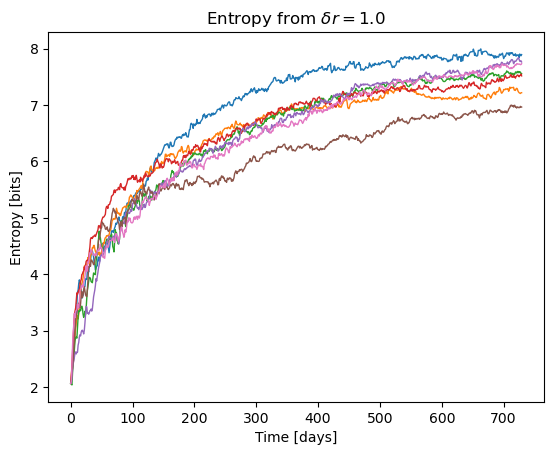

In [8]:
for i in range(7):
    plt.plot(H[i,:], lw=1)
    
plt.xlabel('Time [days]')
plt.ylabel('Entropy [bits]')
plt.title(f"Entropy from $\\delta r = {delta_r}$")

Member 1
Member 2
Member 3
Member 4
Member 5
Member 6
Member 7


Text(0.5, 1.0, 'Entropy from $\\delta r = 0.1$')

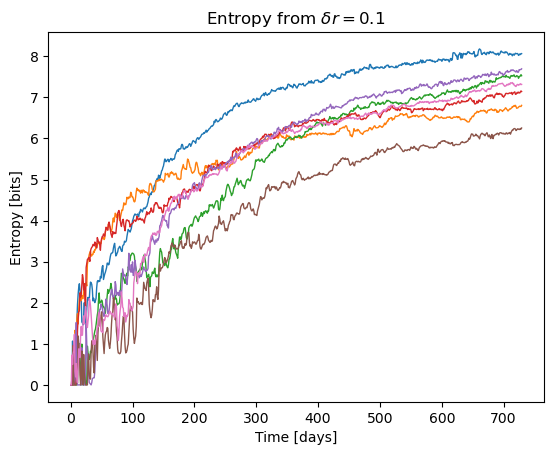

In [10]:
location = 'Cape_Hatteras'
N_members = 7
N_obs = len(P_m.time)
H = np.zeros((N_members, N_obs))
delta_r = 0.1

for member in range(1,N_members+1):
    print(f"Member {member}")
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    H[member-1, :] = P_m['entropy'].values
    
for i in range(7):
    plt.plot(H[i,:], lw=1)
    
plt.xlabel('Time [days]')
plt.ylabel('Entropy [bits]')
plt.title(f"Entropy from $\\delta r = {delta_r}$")